# 热度预测（时序分析）
 ## 本代码功能：对总话题或分类话题数据进行时间顺序的热度预测

In [78]:
import pandas as pd
from datetime import datetime
from collections import Counter
df = pd.read_csv('/dataset/origin_data.csv')

# 读取的文件可以换成由LDA进行分类的不同主题的数据集，仅需更换这个便能进行不同话题的分析

Forward_Num = df["forward_num"]
Comment_Num = df["comment_num"]
Like_Num = df["like_num"]
Publish_time = df["publish_time"]
Publish_time = Publish_time[::-1]
Verify = df['verify_typ']
heat = []
heat2 = []     #这里面放的是按照时间倒着进行的热度

<ipython-input-78-c4b11bad2c77>:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('question2_dataset.csv')


In [79]:
for i in range(1):
    forward_heat = int(Forward_Num[i])
    comment_heat = int(Comment_Num[i])
    like_heat = int(Like_Num[i])
    heat = forward_heat * 0.5 + comment_heat * 0.3 + Like_Num * 0.2
    
    if(Verify[i] == "蓝V认证"):
        heat = heat * 1.3
    elif(Verify[i] == "红V认证"):
        heat = heat * 1.2
    elif(Verify[i] == "黄V认证"):
        heat = heat * 1.1
    else:
        heat = heat
for i in range(len(Verify)-1, -1, -1):
    heat2.append(round(heat[i],2))
Time = []
for i in range(len(Verify)-1, -1, -1):
    Time.append(Publish_time[i][5:])


In [80]:
try:
    start_time = datetime.strptime(Time[0], '%m-%d %H:%M')
except ValueError:
    try:
        start_time = datetime.strptime(Time[0], '%m/%d %H:%M')
    except ValueError:
        try:
            start_time = datetime.strptime(Time[0], '%m月%d日 %H:%M')
        except ValueError:
            start_time = datetime.strptime(Time[0], '%m月%d日 %H:%M:')

seconds=[0]
for i in range(1, len(Time)):
    try:
        time = datetime.strptime(Time[i], '%m-%d %H:%M')
    except ValueError:
        try:
            time = datetime.strptime(Time[i], '%m/%d %H:%M')
        except ValueError:
            try:
                time = datetime.strptime(Time[i], '%m月%d日 %H:%M')
            except ValueError:
                time = datetime.strptime(Time[i], '%m月%d日 %H:%M:')
    delta = (time - start_time).total_seconds()
    seconds.append(int(delta // (3 * 60 * 60)))


In [81]:
# 输出转换后的时间序列
print(seconds[-1])
count = Counter(seconds)
Heat = []    #按照时间进行累加的热度
a = []

# print(count[23])
index = []

for i in range(seconds[-1]+1):
    sum = 0
    for j in range(i+1):
        sum = sum + count[j]
    index.append(sum)
for i in range(seconds[-1]+1):
    sum = 0
    for j in range(index[i]):
        sum = sum + heat2[j]
    Heat.append(round(sum,1))
    
    
#按照每3个小时设立一个时间点，总共350个


350


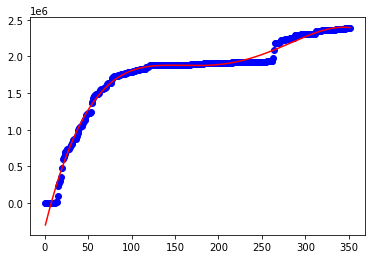

Mean Squared Error: 3213660917.9887543
R2 Score: 0.9898401643911006


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# 原始数据
X = np.arange(1, seconds[-1]+2)
y = np.array(Heat)

# 将X升幂到更高的次数，这里我们选择了4次
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X.reshape(-1,1))

# 初始化线性回归模型
regressor = LinearRegression()

# 在多项式特征上拟合数据
regressor.fit(X_poly, y)

# 预测结果
y_pred = regressor.predict(X_poly)

# 绘制拟合结果
plt.scatter(X, y, color='b')
plt.plot(X, y_pred, color='red')
plt.show()

# 计算均方误差
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# 计算R2分数
r2 = r2_score(y, y_pred)
print("R2 Score:", r2)




In [83]:
# 使用 PolynomialFeatures 生成多项式特征
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X.reshape(-1,1))

# 初始化线性回归模型
regressor = LinearRegression()

# 在多项式特征上拟合数据
regressor.fit(X_poly, y)

# 计算多项式回归方程的导函数
b = regressor.coef_
dy_dx = b[1] + 2*b[2]*X + 3*b[3]*X**2 + 4*b[4]*X**3 


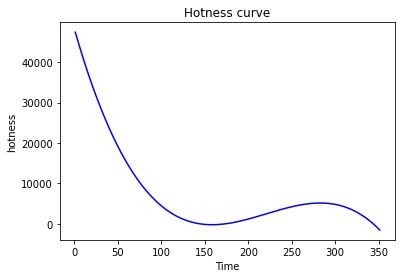

In [84]:
import matplotlib.pyplot as plt

# 绘制数据点的图像
#plt.scatter(X, y, color='red')

# 绘制多项式回归方程的导函数的图像
plt.plot(X, dy_dx, color='blue')

# 设置图像的标题和轴标签
plt.title('Hotness curve')
plt.xlabel('Time')
plt.ylabel('hotness')

# 显示图像
plt.show()


In [85]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

# 生成示例数据


# 创建ColumnDataSource对象
source = ColumnDataSource(data=dict(x=X, y=dy_dx))

# 创建HoverTool对象
hover = HoverTool(tooltips=[("X", "@x"), ("Y", "@y")])

# 创建Figure对象并添加HoverTool
p = figure(tools=[hover])

# 绘制散点图
p.scatter('x', 'y', source=source, size=10)

# 输出到Notebook中
output_notebook()

# 显示图像
show(p)


Loading BokehJS ...